In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import PyPDF2
import io
import cmocean
import multiprocessing
from pdfo import pdfo,Bounds

import xarray as xr

xr.set_options(display_style='html')

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
response_df = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

In [3]:
def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    return pd.DataFrame([tau,q],index=['d','q'],columns=[1,2,3])

In [4]:
response_df.loc['ECS'] = np.nan
response_df.loc['TCR'] = np.nan
for model in response_df.columns:
    fair_params = pd.concat([convert_geoffrey_to_FaIR(response_df.loc[:'F_4x',model].values)],axis=1,keys=[model])
    response_df.loc[['ECS','TCR'],model] = q_to_tcr_ecs(fair_params,F_2x = response_df.loc['F_2x',model]).iloc[:,0]
response_df.loc['RWF'] = response_df.loc['TCR'] / response_df.loc['ECS']

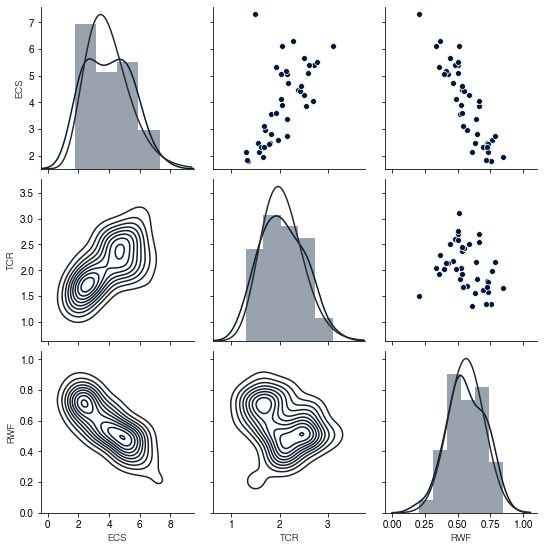

In [5]:
g = sn.PairGrid(response_df.T,vars=['ECS','TCR','RWF'],diag_sharey=False)

g.map_diag(sn.distplot,fit=sp.stats.lognorm)
g.map_lower(sn.kdeplot)
g.map_upper(sn.scatterplot)

In [6]:
response_df.loc[['ECS','TCR','RWF']].quantile([0.05,0.5,0.95],axis=1)

,ECS,TCR,RWF
0.05,1.944262,1.345492,0.358217
0.50,3.978415,2.035489,0.536326
0.95,6.107794,2.713025,0.762762


<AxesSubplot:>

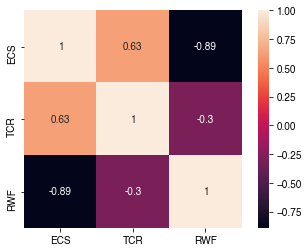

In [7]:
sn.heatmap(response_df.loc[['ECS','TCR','RWF']].T.corr(),square=True,annot=True)

In [8]:
fair_param_df = pd.concat([convert_geoffrey_to_FaIR(x.iloc[:10]) for y,x in response_df.iteritems()],axis=1,keys=response_df.columns)

fair_params_stats = pd.DataFrame(fair_param_df.unstack().reset_index().set_index(['level_2','level_1','level_0']).unstack(2)[0].T.reset_index().values,columns=['model','d1','d2','d3','q1','q2','q3']).set_index('model').apply(pd.to_numeric)

In [9]:
fair_params_stats['ln_d1'] = np.log(fair_params_stats['d1'])
fair_params_stats['ECS'] = response_df.loc['ECS']
fair_params_stats['TCR'] = response_df.loc['TCR']
fair_params_stats['RWF'] = response_df.loc['RWF']

<AxesSubplot:>

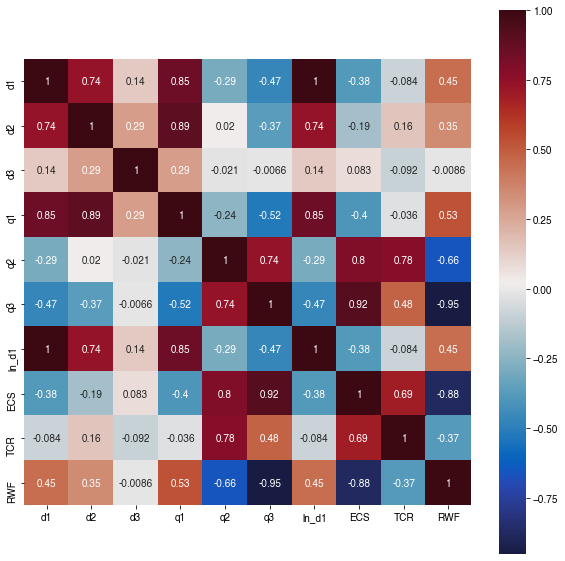

In [11]:
fig,ax= plt.subplots(figsize=(10,10))
sn.heatmap(fair_params_stats.corr(method='spearman'),square=True,annot=True,ax=ax,cmap=cmocean.cm.balance)

In [13]:
response_df.columns

Index(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM',
       'CESM2-WACCM-FV2', 'CIESM', 'CNRM-CM6-1', 'CNRM-CM6-1-HR',
       'CNRM-ESM2-1', 'CanESM5', 'E3SM-1-0', 'EC-Earth3-Veg', 'GFDL-CM4',
       'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-H', 'GISS-E2-2-G',
       'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1', 'SAM0-UNICON',
       'TaiESM1', 'UKESM1-0-LL', 'MIROC-ES2L', 'NorESM2-LM', 'NorESM2-MM'],
      dtype='object')